# Saliency Visualization

Helpful Links:
https://fairyonice.github.io/Saliency-Map-with-keras-vis.html
https://www.machinecurve.com/index.php/2019/11/25/visualizing-keras-cnn-attention-saliency-maps/#introducing-keras-vis

In [1]:
!pip install git+git://github.com/raghakot/keras-vis.git --upgrade --no-deps

  Cloning git://github.com/raghakot/keras-vis.git to /private/var/folders/0n/cnsbrwp110n1_232_8jnhbz80000gn/T/pip-req-build-8id261t5
  Running command git clone -q git://github.com/raghakot/keras-vis.git /private/var/folders/0n/cnsbrwp110n1_232_8jnhbz80000gn/T/pip-req-build-8id261t5
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30855 sha256=d28fd836839a51a0ace9eff1d096ad0cb4dec4f96178a5af467523c19d3776db
  Stored in directory: /private/var/folders/0n/cnsbrwp110n1_232_8jnhbz80000gn/T/pip-ephem-wheel-cache-3s12lzps/wheels/d4/f2/90/2fb26be5bf8493b1fadd7c991dc12b9c47cc47c604d214566a
Successfully built keras-vis
  Attempting uninstall: keras-vis
    Found existing installation: keras-vis 0.5.0
    Uninstalling keras-vis-0.5.0:
      Successfully uninstalled keras-vis-0.5.0


In [2]:
!pip install -r requirements.txt

import keras
import vis

from keras import activations
from keras.models import load_model
from keras.utils import to_categorical, CustomObjectScope

import matplotlib.pyplot as plt

from models import AlphaNet

import numpy as np
from numpy import loadtxt

from tools import *
from train import *

from vis.visualization import visualize_saliency
from vis.utils import utils


  Using cached tensorflow-2.1.0-cp37-cp37m-macosx_10_11_x86_64.whl (120.8 MB)
  Using cached numpy-1.18.1-cp37-cp37m-macosx_10_9_x86_64.whl (15.1 MB)
  Using cached matplotlib-3.1.1-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl (14.4 MB)
  Using cached tensorflow_estimator-2.1.0-py2.py3-none-any.whl (448 kB)
  Using cached tensorboard-2.1.1-py3-none-any.whl (3.8 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:


      Successfully uninstalled tensorflow-estimator-1.15.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.0
    Uninstalling numpy-1.16.0:
      Successfully uninstalled numpy-1.16.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.0.3
    Uninstalling matplotlib-3.0.3:
      Successfully uninstalled matplotlib-3.0.3


Using TensorFlow backend.


In [3]:
assert int(tf.__version__[0]) >= 2

In [4]:
# load model
custom_metrics = {
    "top3_accuracy": top3_acc,
    "top5_accuracy": top5_acc
}
model = load_model('../AlphaNet_v2.h5', custom_objects=custom_metrics) 
model.summary()


Model: "AlphaNet_v2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 64, 64, 32)        4736      
_________________________________________________________________
batch_normalization_43 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
spatial_dropout2d_25 (Spatia (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 64)        51264     
_________________________________________________________________
batch_normalization_44 (Batc (None, 32, 32, 64)        

In [5]:
X_train, y_train = load_data()
X_val, y_val = load_data("val")
X_test, _ = load_data("test")

y_train = to_categorical(y_train, 200)
y_val = to_categorical(y_val, 200)

Loading train data

Finished loading train data

Loading val data

Finished loading val data

Loading test data

Finished loading test data



In [6]:
labels = get_label_dict()
words = get_word_labels()

test_images = os.listdir("data/tiny-imagenet-200/test/images/")
assert len(X_test) == len(test_images)

Loading labels

Done

Loading words

Done



In [7]:
with CustomObjectScope({"top3_accuracy": top3_acc, "top5_accuracy": top5_acc,}):
    layer_index = -1
    model.layers[layer_index].activation = activations.linear
    model = utils.apply_modifications(model)  

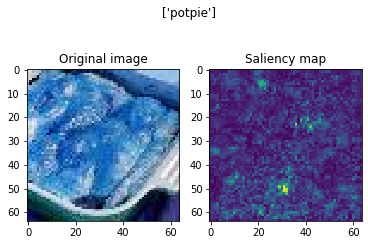

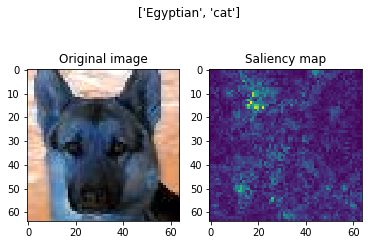

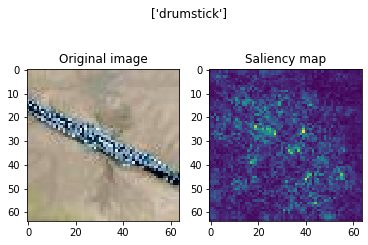

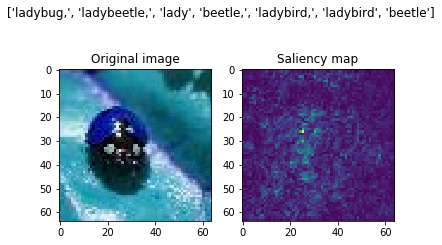

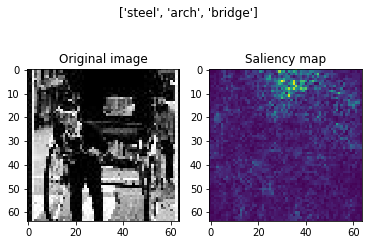

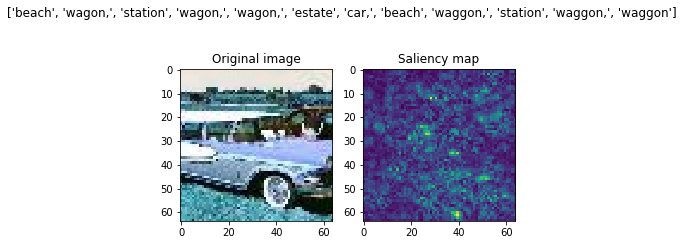

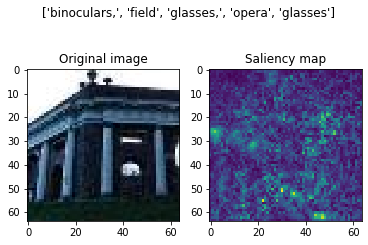

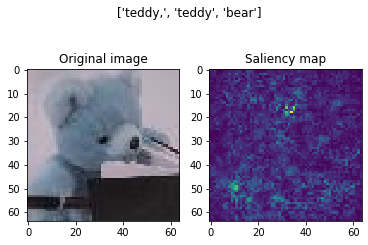

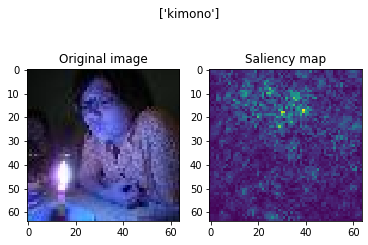

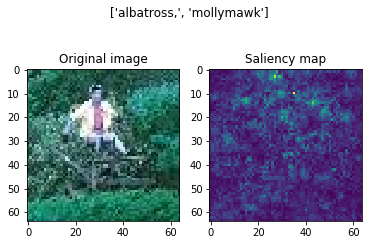

In [8]:
# indices_to_visualize = [ 5, 19, 38, 82, 111, 76, 194 ]
indices_to_visualize = np.random.choice(len(X_val), 10)

with CustomObjectScope({"top3_accuracy": top3_acc, "top5_accuracy": top5_acc,}):

    for index_to_visualize in indices_to_visualize:
        # Get input
        input_image = X_val[index_to_visualize]
        input_class = np.argmax(y_val[index_to_visualize])
        
        # Matplotlib preparations
        fig, axes = plt.subplots(1, 2)
        
        # Generate visualization
        visualization = visualize_saliency(model, layer_index, filter_indices=input_class, seed_input=input_image)

        y_pred = model.predict(input_image[np.newaxis,...])
        class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]

        class_idx = class_idxs_sorted[0]

        axes[0].imshow(input_image) 
        
        axes[0].set_title('Original image')
        axes[1].imshow(visualization)
        axes[1].set_title('Saliency map')
        fig.suptitle(words[labels[class_idx]])
        plt.show()
